Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 04-January-2026

In [1]:
# Import libraries
import pandas as pd
pd.options.mode.chained_assignment = None  
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean

In [2]:
# Settings 
data_dir = r'../data/'
syn_thresh = 5

In [3]:
# Load connections
df_connectivity = pd.read_csv(data_dir+'manc_v121_connections.csv')

# Load classifications
df_class = pd.read_csv(data_dir+'manc_v121_classifications.csv')

# Rename columns for consistency with FlyWire dataset
df_connectivity = df_connectivity.rename(columns={"bodyId_pre": "pre_root_id", "bodyId_post": "post_root_id", "weight": "syn_count"}, errors="raise")

df_class = df_class.rename(columns={"bodyId": "root_id", 
                                    "class": "super_class", 
                                    "predictedNt": "nt_type",
                                    "predictedNtProb": "nt_type_score"}, 
                           errors="raise")

# Load neurons of interest
df_neurons_of_interest = pd.read_csv(data_dir + 'neurons_of_interest.csv')

In [4]:
# Set source neurons
dict_ids = {}

# RR axis
dict_ids['DNp52'] = [151717] 
dict_ids['DNg45'] = [18010, 18189] 
dict_ids['DNg101'] = [13257, 13387] 
dict_ids['DNp13'] = [10819, 10962] 
dict_ids['DNge082'] = [15426, 15155] 
dict_ids['DNg102'] = [11968, 11798] 
dict_ids['DNg44'] = [13834, 13845] 
dict_ids['DNge103'] = [11731, 11488] 
dict_ids['DNp66'] = [13053, 13053]
dict_ids['DNp45'] = [17575, 16842]

# BPN axis
dict_ids['DNg55'] = [14904] 
dict_ids['DNge053'] = [13291, 13184] 
dict_ids['DNpe053'] = [15016, 14999] 
dict_ids['DNpe020'] = [22586, 20978, 21696, 26296] 
dict_ids['DNd05'] = [12898, 13238] 
dict_ids['DNge150'] = [13548, 12613] 
dict_ids['DNp64'] = [17113, 17467] 
#dict_ids['DNge138'] = [] 

# RR-BPN axis
dict_ids['DNge048'] = [12025, 11856] 
dict_ids['DNp68'] = [15134, 14585] 
dict_ids['DNpe042'] = [190167, 21069] 
dict_ids['DNd05'] = [12898, 13238] 
dict_ids['DNge050'] = [11120, 10279] 

source_ids = list(itertools.chain(*list(dict_ids.values())))

In [5]:
# Sum synapses across neuropils
df_connectivity = df_connectivity.groupby(['pre_root_id','post_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)

In [6]:
# Remove connections between neurons smaller than syn_thresh 
df_connectivity = df_connectivity[df_connectivity.syn_count>=syn_thresh]

In [7]:
df_class.super_class.unique().tolist()

['descending neuron',
 'sensory neuron',
 'intrinsic neuron',
 'motor neuron',
 'ascending neuron',
 'efferent neuron',
 'TBD',
 'sensory ascending',
 'efferent ascending',
 'glia',
 'Interneuron TBD',
 nan]

In [8]:
# Find motor neurons
motor_ids = df_class.root_id[df_class.super_class == 'motor neuron'].tolist()

# Find premotor neurons
premotor_ids = df_connectivity.pre_root_id[~df_connectivity.pre_root_id.isin(motor_ids) 
                                           & (df_connectivity.post_root_id.isin(motor_ids))].unique().tolist()

# Find pre-premotor neurons
pre_premotor_ids = df_connectivity.pre_root_id[(~df_connectivity.pre_root_id.isin(motor_ids+premotor_ids)) 
                                                & (df_connectivity.post_root_id.isin(premotor_ids))].unique().tolist()

In [10]:
# Trim connectivity dataframe
df_connectivity_post = df_connectivity[df_connectivity.pre_root_id.isin(source_ids)]

In [11]:
# Add neuron type
neuron_type = []
for index, row in df_connectivity_post.iterrows():
    root_id = row.post_root_id
    if root_id in motor_ids:
        neuron_type.append('motor')
    elif root_id in premotor_ids:
        neuron_type.append('premotor')
    elif root_id in pre_premotor_ids:
        neuron_type.append('pre_premotor')
    else:
        neuron_type.append('other')

df_connectivity_post['neuron_type'] = neuron_type

In [12]:
df_connectivity_post

,pre_root_id,post_root_id,syn_count,neuron_type
659295,11120,10630,246,premotor
2051266,15134,11393,224,other
1563203,13387,10235,220,premotor
1909384,14585,11170,205,other
1408071,12898,11074,201,premotor
...,...,...,...,...
1695038,13834,12346,5,premotor
1694996,13834,11560,5,premotor
1695020,13834,11967,5,premotor
1694959,13834,11074,5,premotor


In [21]:
df_neurons_of_interest[df_neurons_of_interest.super_class=='descending']

,connectome_dataset,connectome_id,cell_type,community_name,super_class,motor_program,motor_function
34,flywire_v783,720575940621068464,DNb08,DNb08,descending,walking,initiation
35,flywire_v783,720575940642549467,DNb08,DNb08,descending,walking,initiation
36,flywire_v783,720575940630334658,DNb08,DNb08,descending,walking,initiation
37,flywire_v783,720575940634459290,DNb08,DNb08,descending,walking,initiation
38,flywire_v783,720575940626730883,DNg97,oDN1,descending,walking,initiation
...,...,...,...,...,...,...,...
168,manc_v121,21069,DNpe042,DNpe042,descending,NaN,NaN
169,manc_v121,190167,DNpe042,DNpe042,descending,NaN,NaN
170,manc_v121,17575,DNp45,DNp45,descending,NaN,NaN
171,manc_v121,16842,DNp45,DNp45,descending,NaN,NaN


In [24]:
# Find specific neurons of interest
root_ids_of_interest = df_neurons_of_interest.connectome_id[(df_neurons_of_interest.connectome_dataset.str.contains('manc')) & (df_neurons_of_interest.super_class!='descending')].tolist()
df_of_interest = df_connectivity_post[df_connectivity_post.post_root_id.isin(root_ids_of_interest)]

# Add neuron names
pre_name, post_name = [], []
pre_root_ids = df_of_interest.pre_root_id.tolist()
post_root_ids = df_of_interest.post_root_id.tolist()
for root_id in pre_root_ids:
    pre_name.append([key for key, values in dict_ids.items() if root_id in values][0])
for root_id in post_root_ids:
    post_name.append(df_neurons_of_interest.community_name[df_neurons_of_interest.connectome_id==root_id].item())
df_of_interest["pre_name"] = pre_name
df_of_interest["post_name"] = post_name
df_of_interest

,pre_root_id,post_root_id,syn_count,neuron_type,pre_name,post_name
659298,11120,10690,163,premotor,DNge050,E1
659214,11120,10072,147,premotor,DNge050,E1
189136,10279,10559,123,premotor,DNge050,E1
189152,10279,10707,92,premotor,DNge050,E1
659285,11120,10558,85,premotor,DNge050,E1
189131,10279,10498,66,premotor,DNge050,E1
659499,11120,12443,60,premotor,DNge050,Chief 9A
660149,11120,165560,57,premotor,DNge050,Chief 9A
189379,10279,13157,48,premotor,DNge050,Chief 9A
659523,11120,12804,36,premotor,DNge050,Chief 9A


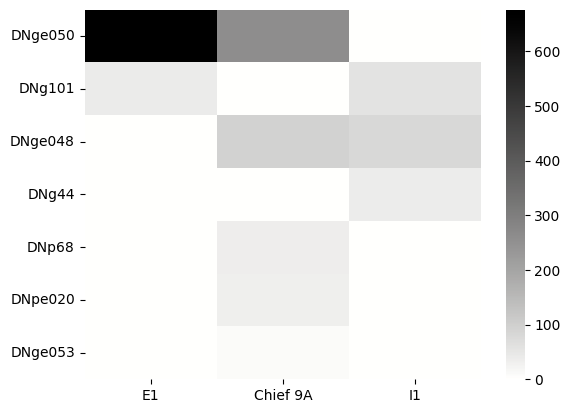

In [25]:
# Plot connectivity with sorted of interest 
pre_names = df_of_interest.pre_name.unique()
post_names = df_of_interest.post_name.unique()
conn_mat = np.zeros((len(pre_names),len(post_names)))

df_of_interest_summed = df_of_interest.groupby(['pre_name','post_name'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)

for pre_index, pre_name in enumerate(pre_names):
    for post_index, post_name in enumerate (post_names): 
        conn_mat[pre_index, post_index] = df_of_interest_summed.syn_count[(df_of_interest_summed.pre_name==pre_name) & (df_of_interest_summed.post_name==post_name)].sum()

cmap = cmocean.cm.gray_r
sns.heatmap(conn_mat, cmap=cmap, yticklabels=pre_names, xticklabels=post_names)
plt.show()

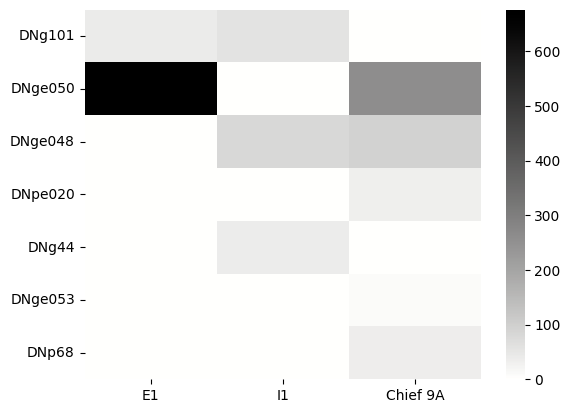

In [26]:
# Plot sorted connectivity with neurons of interest 
row_sort_index = [1,0,2,5,3,6,4]
column_sort_index = [0,2,1]

conn_mat_sorted = conn_mat[row_sort_index,:]
conn_mat_sorted = conn_mat_sorted[:,column_sort_index]

sns.heatmap(conn_mat_sorted, cmap=cmap, yticklabels=pre_names[row_sort_index], xticklabels=post_names[column_sort_index])
#plt.savefig(r"C:\Users\Chris\Desktop\figure.eps", bbox_inches="tight", transparent=True)
plt.show()

In [29]:
# Initialize synapse dictionary
neuron_types = df_connectivity_post.neuron_type.unique().tolist() 
dict_synapses = {}
for source_id in source_ids:
    dict_synapses[source_id] = {}
    for neuron_type in neuron_types:
        dict_synapses[source_id][neuron_type] = 0

In [30]:
# Populate synapse dictionary
for source_id in source_ids:
    # Use original df_connectivity to get total synapse count
    syn_count_total = df_connectivity.syn_count[df_connectivity.pre_root_id == source_id].sum().item()
    
    for neuron_type in neuron_types:
        syn_count = df_connectivity_post.syn_count[(df_connectivity_post.pre_root_id == source_id) & (df_connectivity_post.neuron_type == neuron_type)].sum().item()
        dict_synapses[source_id][neuron_type] += syn_count / syn_count_total

In [31]:
# Build connectivity matrix
connectivity_matrix = np.zeros((len(source_ids),len(neuron_types)))
for source_index, source_id in enumerate(dict_synapses.keys()):
    for neuron_type_index, neuron_type in enumerate(neuron_types):
        connectivity_matrix[source_index,neuron_type_index] = dict_synapses[source_id][neuron_type]

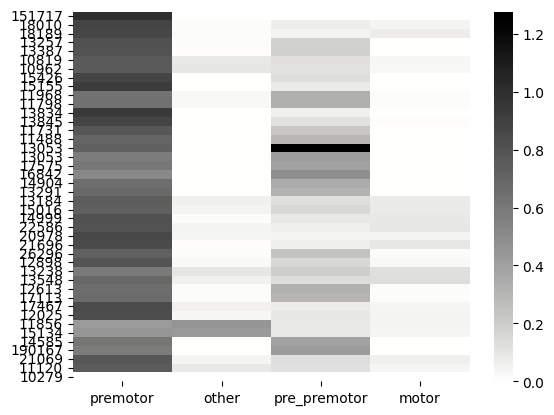

In [32]:
# Plot connectivity matrix
cmap = cmocean.cm.gray_r

sns.heatmap(connectivity_matrix,
            yticklabels = source_ids,
            xticklabels = neuron_types,
            cmap = cmap)
plt.show()

In [33]:
# Average rows for the same source neuron type
neuron_names = list(dict_ids.keys())
connectivity_matrix_grouped = np.zeros((len(neuron_names),np.size(connectivity_matrix,axis=1)))
for key_index, key in enumerate(neuron_names):
    n_neurons = len(dict_ids[key])   
    if key_index == 0:
        start_index = 0
    else:
        start_index = end_index 
    end_index = start_index + n_neurons
    
    connectivity_matrix_grouped[key_index,:] = np.mean(connectivity_matrix[start_index:end_index,],axis=0)

connectivity_matrix = connectivity_matrix_grouped
del connectivity_matrix_grouped

In [34]:
# Sort connectivity matrix 
neuron_names = list(dict_ids.keys())

# Sort rows based on clustering in manc_neuropil_analysis.ipynb
sort_index = [2,1,4,13,6,7,5,16,20,14,17,0,12,3,11,15,18,8,19,9,10]
connectivity_matrix = connectivity_matrix[[i for i in sort_index],:]
neuron_names = [neuron_names[i] for i in sort_index]

# Sort columns
sort_list = ['motor','premotor','pre_premotor','other']
sort_index = [neuron_types.index(i) for i in sort_list]
connectivity_matrix = connectivity_matrix[:, [i for i in sort_index]]
neuron_types = [neuron_types[i] for i in sort_index]

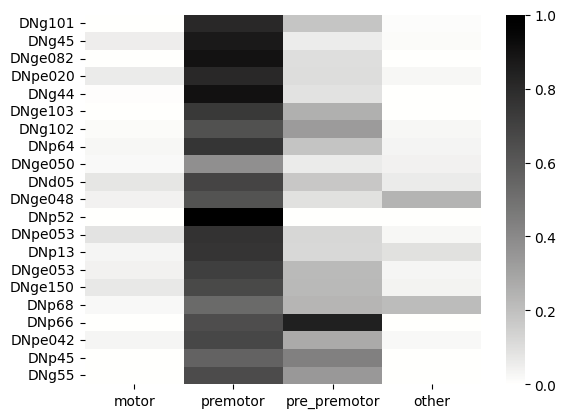

In [35]:
# Plot sorted connectivity with neuron classes
cmap = cmocean.cm.gray_r

sns.heatmap(connectivity_matrix,
            yticklabels = neuron_names,
            xticklabels = neuron_types,
            cmap = cmap,
            vmax = 1)
#plt.savefig(r"C:\Users\Chris\Desktop\figure.eps", bbox_inches="tight", transparent=True)
plt.show()

In [36]:
# Compute mean output per neuropil per cluster
clusters = [[0,1,2,3,4,5,6,7,8,9,10], [12,13,14,15,16,17,18,19,20]] # From manc_neuropil_analysis.ipynb
cluster_means = np.zeros((len(clusters),len(neuron_types)))
for cluster_index, cluster in enumerate(clusters):
    cluster_means[cluster_index,:] = np.mean(connectivity_matrix[cluster,:],axis=0)

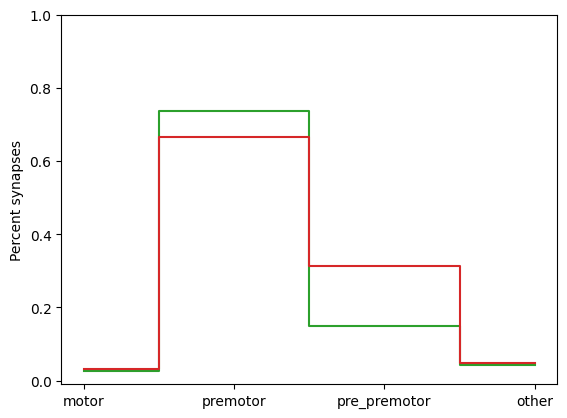

In [47]:
# Plot cluster means
colors = ['tab:green','tab:red']
fig, ax = plt.subplots()
for cluster_index, _ in enumerate(clusters):
    plt.step(range(len(cluster_means[cluster_index,:])),cluster_means[cluster_index,:], color=colors[cluster_index], where='mid')

plt.ylim([-0.01,1])
plt.xticks([0,1,2,3])
ax.set_xticklabels(neuron_types)
plt.ylabel('Percent synapses')
#plt.savefig(r"C:\Users\Chris\Desktop\figure.eps", bbox_inches="tight", transparent=True)
plt.show()